<h1>Kernel/Covariance (?) Functions</h1>

In [129]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,6)

%matplotlib inline

The covariance (kernel) function is the heart of Support Vector Machines and Gaussian Processes.  In essense, a kernel function says how "similar" any two given points (or random variables, in the case of GP are).  As such, they contain a large number of assumptions about the structure of our data and the correct choice is imperative.


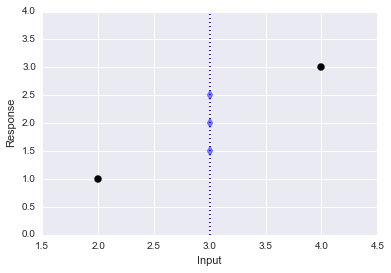

In [2]:
X = [2, 4]
Y = [1, 3]

sns.set_style("darkgrid")
plt.scatter(X, Y, s=50, color="black")
plt.plot([3,3], [0, 4], ":", color="blue")
plt.ylim(0, 4)
plt.scatter([3, 3, 3],[1.5, 2, 2.5], marker="d", s=50, color="blue", alpha=0.5)
plt.ylabel("Response")
plt.xlabel("Input")
plt.show()

Suppose we have observed the input and response for the two black data points above - we observe a new data point at $x = 3$, What would we predict?  In essense, how similar is this point to our existing data?  In order to do this, we'll need to define what constitutes a similarity function.


<h3>The Inner Product</h3>
The simplest case of a similarity measure we have encountered before is the dot product.  Remember this from Calc?

$$Cos(\theta)\ ||A|| \ ||B|| \ = A \cdot B $$

If we have two vectors $A = [0, 1]$ and $B = [0, 1]$, then $A \cdot B = 1$.  If our vectors are instead $A = [1, 0], B = [0, 1]$, then $A \cdot B = 0$. Taking the inverse cosine of each reveals the angle between each vector, 0 and 90 degrees respectively.


Now for the above case, lets calculate the similarity between all of the points in X (that we have observed the response for).

$$ X = [2, 4] $$
$$  X.T \cdot X = \begin{bmatrix}4\ 8 \\8\ 16\end{bmatrix} $$

The inverse of this matrix is the covariance matrix, which also arises during linear regression.  This gets into way more linear algebra than I wanted to...kind of just some rambling


The advantage of kernel functions other than the dot product is that many of them have generate a kernel matrix with infinite rank.  The dot product kernel is limited rank, and so It can only be used to fit p parameters.

The most commonly used kernel, the squared exponential kernel.  also known as the gaussian kernel or radial basis function.  Selects very smooth (sometimes too smooth) functions

$$k_se(x, x') = \sigma^2 exp{-\frac{(x - x')^2}{2l^2}}$$

In [3]:
def kernel_se(a, b, lengthscale=1):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(sqdist * (-0.5 / lengthscale**2))

    

def GP(N, n, function, kernel_choice, lengthscale=1, s=0.00005):

    # Perform 2 inital evaulations of our function
    X = np.random.uniform(-20, 20, size=(N,1))
    y = function(X)
    K = kernel_choice(X, X, lengthscale)
    L = np.linalg.cholesky(K + s*np.eye(N))

    # points we're going to make predictions at.
    Xtest = np.linspace(-20, 20, n).reshape(-1,1)

    # compute the mean at our test points.
    Lk = np.linalg.solve(L, kernel_choice(X, Xtest, lengthscale))
    mu = np.dot(Lk.T, np.linalg.solve(L, y))

    # compute the variance at our test points.
    K_ = kernel_choice(Xtest, Xtest, lengthscale)
    s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
    s = np.sqrt(s2)
    s.shape = mu.shape
    
    sns.set_style("darkgrid")
    plt.figure(figsize=(10, 10))
    plt.gca().fill_between(Xtest[:,0], (mu+3*s)[:,0], (mu-3*s)[:,0], color="#dddddd")
    plt.scatter(X, y, s=40, color="red", alpha=0.7)
    plt.plot(Xtest, mu, lw=2, color="black", alpha=0.7)
    plt.plot(Xtest, function(Xtest), lw=1, color="blue", linestyle=":")
    plt.xlim(-20, 20)
    plt.title("Mean Prediction $\pm 3\sigma$")
    plt.show()

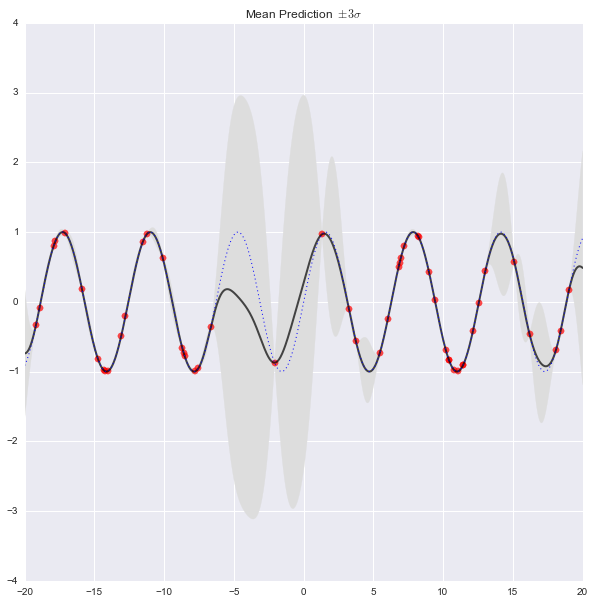

In [207]:
f = lambda x: np.sin(x)
GP(50, 1000, f, kernel_se, lengthscale=1)

In [5]:
def kernel_periodic(a, b, lengthscale=1, period=30):
    if (a.shape == b.shape):
        absdist = np.abs(a - b.T)
    else:
        z = np.ones((a.shape[0], b.shape[0]))
        absdist = np.abs(a * z - b.T * z)
    return np.exp((-2/lengthscale**2) * np.sin((np.pi/period) * absdist)**2)
        

<h3>Periodic Kernel</h3>
Derived by David MacKay, the periodic kernel allows you to model functions which repeat themselves exactly
$$k_{Per}(x,x′)=\sigma^2exp(−2sin^2(\frac{\pi}{p}|x−x′|)ℓ^2) $$

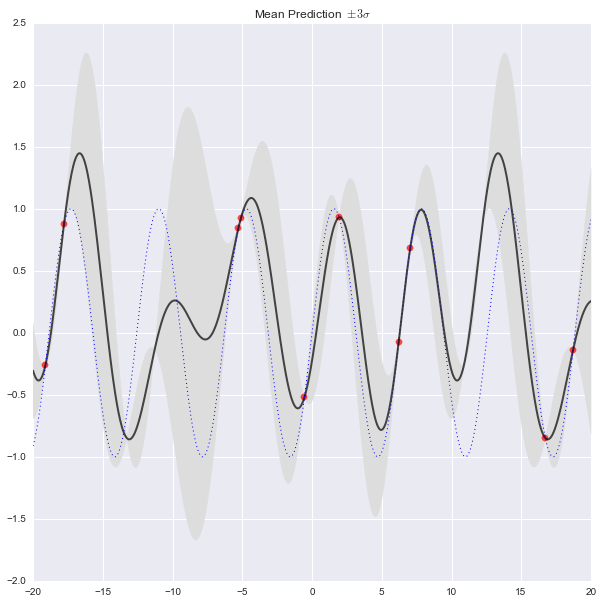

In [6]:
f = lambda x: np.sin(x)
GP(10, 1000, f, kernel_periodic, lengthscale=0.5)

<h3>Locally Periodic Kernel</h3>
The locally periodic kernel models periodic functions which repeat themselves over time but also vary. it is the product of a periodic and squared exponential kernel

$$k_{lp}(x, x') = k_{Per}(x, x') \cdot k_{se}(x, x')$$

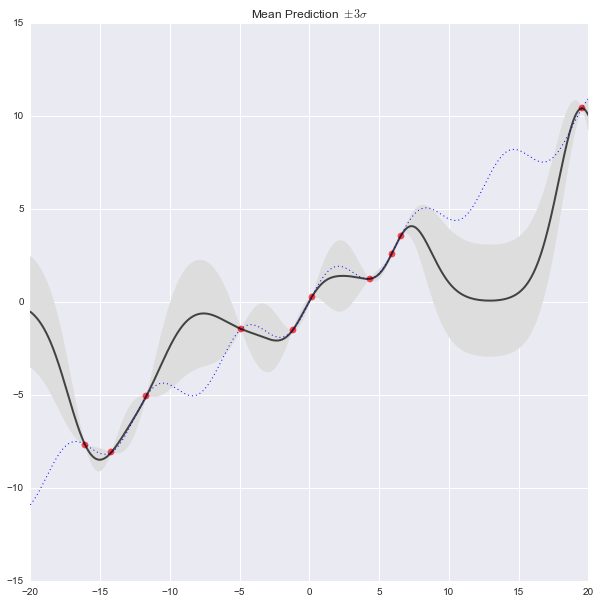

In [7]:
def kernel_lp(a, b, lengthscale=1, period=10):
    left = kernel_periodic(a, b, lengthscale, period)
    right = kernel_se(a, b, lengthscale)
    return left * right
    
f = lambda x: np.sin(x) + 0.5*x
GP(10, 1000, f, kernel_lp, lengthscale=2)

In [114]:
def kernel(a, b, lengthscale=1):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(sqdist * (-0.5 / lengthscale**2))

N = 100
n = 1000
s = 0.00001
ls = 1
function = lambda x: np.sin(x)

X = np.random.uniform(-20, 20, size=(N,1))
Xtest = np.linspace(-20, 20, n).reshape(-1,1)
y = function(X)

K = kernel(X, X, ls)
K_star = kernel(X, Xtest, ls)
K_test = kernel(Xtest, Xtest, ls)

L = np.linalg.cholesky(K + s*np.eye(N))
Alpha = np.linalg.solve(L.T ,np.linalg.solve(L, y))
Mu = np.dot(K_star.T, Alpha)

V = np.linalg.solve(L, K_star)
s2 = np.diag(K_test) - np.sum(V**2, axis=0)
s = np.sqrt(s2)
LogLike = ((-0.5) * np.dot(y.T, Alpha) - np.trace(L) - (N / 2.0) * np.log(2 * np.pi))[0][0]

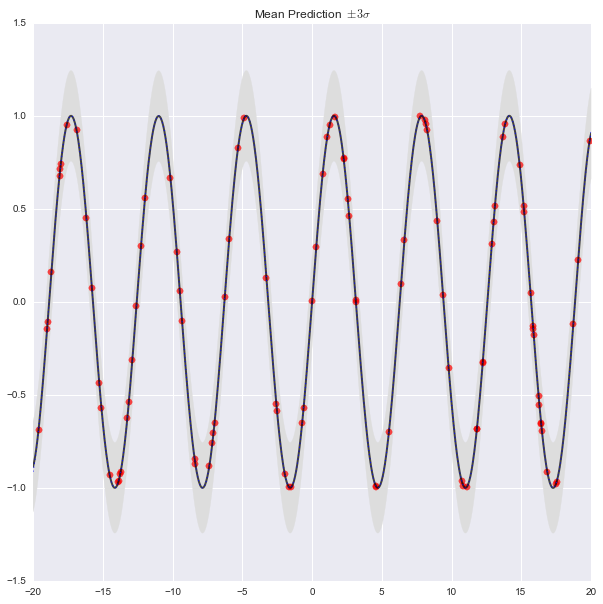

In [115]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 10))
plt.gca().fill_between(Xtest[:,0], (Mu+3*s)[:,0], (Mu-3*s)[:,0], color="#dddddd")
plt.scatter(X, y, s=40, color="red", alpha=0.7)
plt.plot(Xtest, Mu, lw=2, color="black", alpha=0.7)
plt.plot(Xtest, function(Xtest), lw=1, color="blue", linestyle=":")
plt.xlim(-20, 20)
plt.title("Mean Prediction $\pm 3\sigma$")
plt.show()

In [116]:
LogLike

-125.91151639125526

In [119]:
import GPy

In [126]:
m = GPy.examples.regression.sparse_GP_regression_1D(plot=False, optimize=False)

creating /var/folders/k1/f4b4x9xj12qfpw66hntwlkjh0000gn/T/scipy-jonahwilliams-T31RcP/python27_intermediate/compiler_ae297db4d35d5cad7453fcb6005c28a9

 Weave compilation failed. Falling back to (slower) numpy implementation



In [127]:
print m


Name                 : sparse gp mpi
Log-likelihood       : -407.682625928
Number of Parameters : 8
Parameters:
  sparse_gp_mpi.           |  Value   |  Constraint  |  Prior  |  Tied to
  inducing inputs          |  (5, 1)  |              |         |         
  rbf.variance             |     1.0  |     +ve      |         |         
  rbf.lengthscale          |     1.0  |     +ve      |         |         
  Gaussian_noise.variance  |     1.0  |     +ve      |         |         


{'dataplot': [<matplotlib.lines.Line2D at 0x10d6a7e10>],
 'gpplot': [[<matplotlib.lines.Line2D at 0x10a561990>],
 'inducing_inputs': [<matplotlib.lines.Line2D at 0x10a5613d0>]}

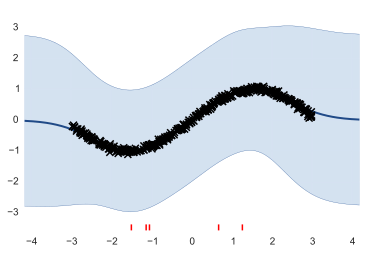

In [130]:
m.plot()